In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ario3.simulation import Simulation
from ario3.indicators import Indicators
import json
import pandas as pd
import numpy as np
import pathlib
import csv

params = { "storage_dir": "../../../Data/BigScaleTest/",
            "results_storage": "results",
            "bool_run_detailled": True,
            "register_stocks": True,
            "psi_param": 0.9,
            "model_time_step": 1,
            "timestep_dividing_factor": 100,
            "inventory_restoration_time": 40,
            "alpha_base": 1.0,
            "alpha_max": 1.25,
            "alpha_tau": 365,
            "rebuild_tau": 90,
            "n_timesteps": 365,
            "min_duration": (150 // 100) * 25,
            "impacted_region_base_production_toward_rebuilding": 0.002,
            "row_base_production_toward_rebuilding": 0.0,
            "mrio_params_file":"/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BigScaleTest/mrio_params.json"
}

event_template = {
        "aff-regions": [
            "FR"
        ],
        "aff-sectors": [
            'Mining of coal and lignite; extraction of peat (10)',
            'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
            'Extraction of natural gas and services related to natural gas extraction, excluding surveying',
            'Extraction, liquefaction, and regasification of other petroleum and gaseous materials',
            'Mining of uranium and thorium ores (12)',
            'Mining of iron ores',
            'Mining of copper ores and concentrates',
            'Mining of nickel ores and concentrates',
            'Mining of aluminium ores and concentrates',
            'Mining of precious metal ores and concentrates',
            'Mining of lead, zinc and tin ores and concentrates',
            'Mining of other non-ferrous metal ores and concentrates', 
            'Quarrying',
            'Manufacture of textiles (17)',
            'Manufacture of wearing apparel; dressing and dyeing of fur (18)',
            'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)',
            'Manufacture of coke oven products',
            'Petroleum Refinery',
            'Processing of nuclear fuel',
            'Plastics, basic',
            'Fertilisers',
            'Chemicals nec',
            'Manufacture of rubber and plastic products (25)',
            'Manufacture of glass and glass products',
            'Manufacture of ceramic goods',
            'Manufacture of construction products and cement',
            'Manufacture of other non-metallic mineral products n.e.c.',
            'Manufacture of basic iron and steel and of ferro-alloys and first products thereof',
            'Precious metals production', 
            'Aluminium production',
            'Lead, zinc and tin production', 
            'Copper production',
            'Other non-ferrous metal production',
            'Casting of metals',
            'Manufacture of fabricated metal products, except machinery and equipment (28)',
            'Manufacture of machinery and equipment n.e.c. (29)',
            'Manufacture of office machinery and computers (30)',
            'Manufacture of electrical machinery and apparatus n.e.c. (31)',
            'Manufacture of medical, precision and optical instruments, watches and clocks (33)',
            'Manufacture of transport equipment (34,35)',
            'Manufacture of furniture; manufacturing n.e.c. (36)',
            'Recycling of waste and scrap',
            'Transmission and distribution of electricity',
            'Transport via railways',
            'Other land transport',
            'Post and telecommunications (64)'
        ],
        "dmg-distrib-regions": [
            1
        ],
        "dmg-distrib-sectors-type": "gdp",
        "dmg-distrib-sectors": [],
        "duration": 1,
        "name": "0",
        "occur": 5,
        "q_dmg": 100000000,
        "rebuilding-sectors": {
            "Construction (45)":0.15,
            "Manufacture of machinery and equipment n.e.c. (29)" : 0.20,
            "Manufacture of furniture; manufacturing n.e.c. (36)" : 0.20,
            "Manufacture of office machinery and computers (30)": 0.15,
            "Manufacture of medical, precision and optical instruments, watches and clocks (33)": 0.05,
            "Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries": 0.15,
            "Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)" : 0.05,
            "Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)": 0.05
        }
    }

# Fully display a dataframe (all lines and columns)
def display_f(df):
    with pd.option_context('display.max_colwidth', None), pd.option_context('display.max_rows', None), pd.option_context('display.max_columns', None):
        display(df)

In [14]:
import pymrio as pym
import pickle

VA_idx = np.array(['Taxes less subsidies on products purchased: Total',
       'Other net taxes on production',
       "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
       "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
       "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",
       'Operating surplus: Consumption of fixed capital',
       'Operating surplus: Rents on land',
       'Operating surplus: Royalties on resources',
       'Operating surplus: Remaining net operating surplus'], dtype=object)

VA_idx

df = exio.satellite.F
df = df.loc[VA_idx]

df = df.sum(axis=0)
gdp_df = df.groupby('region').sum()

gdp_df_pct = gdp_df*1000000
#gdp_df_pct

In [6]:
from datetime import datetime

res = []
model = None
for psi in [0.9]:
    for inv_tau in [90]:
        for qdmg in [0.005]:
            for region_aff in ['FR']:
                dmg = gdp_df_pct[region_aff] * qdmg
                event = event_template.copy()
                sim_params = params.copy()
                event['aff-regions'] = region_aff
                event['q_dmg'] = dmg
                sim_params['psi_param'] = psi
                sim_params['inventory_restoration_time'] = inv_tau
                sim_params["results_storage"] = params["results_storage"]+"/"+region_aff+'_'+'qdmg_'+str(dmg/1000000000).replace(".","_")+"G"+'_Psi_'+str(sim_params['psi_param']).replace(".","_")+"_inv_tau_"+str(sim_params['inventory_restoration_time'])
                if model is None:
                    model = Simulation(sim_params, mrio_path)
                else:
                    model.update_params(sim_params)
                    model.reset_sim_full()
                model.read_events_from_list([event])
                model.loop()
                final_step = model.current_t
                indic = Indicators.from_storage_path(pathlib.Path(sim_params['storage_dir']), params=sim_params)
                indic.update_indicators()
                res_a = indic.indicators.copy()
                indic.write_indicators()
                res_a['region'] = region_aff
                res_a['q_dmg'] = event['q_dmg']
                res_a['psi'] = psi
                res_a['inv_tau'] = inv_tau
                res.append(res_a)
#except KeyboardInterrupt:
#    with (pathlib.Path(params['storage_dir'])/("indicators_"+datetime.now().strftime("%Y%m%d-%H%M%S")+".csv")).open('w') as f:
#        w = csv.DictWriter(f, res[0].keys())
#        w.writeheader()
#        w.writerows(res)

#with (pathlib.Path(params['storage_dir'])/("indicators_"+datetime.now().strftime("%Y%m%d-%H%M%S")+".csv")).open('w') as f:
#    w = csv.DictWriter(f, res[0].keys())
#    w.writeheader()
#    w.writerows(res)

[INFO]:: ario3.mriosystem : Monetary unit is: 1000000


Processed: Year: 0  ~   0% ETA:  --:--:--                                      

{
    "storage_dir": "../../../Data/BigScaleTest/",
    "results_storage": "results/FR_qdmg_12_128263842016764G_Psi_0_9_inv_tau_90",
    "bool_run_detailled": true,
    "register_stocks": true,
    "psi_param": 0.9,
    "model_time_step": 1,
    "timestep_dividing_factor": 100,
    "inventory_restoration_time": 90,
    "alpha_base": 1.0,
    "alpha_max": 1.25,
    "alpha_tau": 365,
    "rebuild_tau": 90,
    "n_timesteps": 365,
    "min_duration": 25,
    "impacted_region_base_production_toward_rebuilding": 0.002,
    "row_base_production_toward_rebuilding": 0.0,
    "mrio_params_file": "/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BigScaleTest/mrio_params.json"
}


Processed: Year: 360  ~  98% ETA:   0:00:05                                    

[WARNING]:: ario3.simulation : Economy seems to have found an equilibrium


Processed: Year: 365  ~ 100% Time:  0:06:30                                    


In [3]:
psi=0.9
inv_tau= 90
qdmg=0.005
region_aff='BE'
dmg = gdp_df_pct[region_aff] * qdmg
event = event_template.copy()
sim_params = params.copy()
event['aff-regions'] = region_aff
event['q_dmg'] = dmg
sim_params['psi_param'] = psi
sim_params['inventory_restoration_time'] = inv_tau
sim_params["results_storage"] = params["results_storage"]+"/"+region_aff+'_'+'qdmg_'+str(dmg/1000000000).replace(".","_")+"G"+'_Psi_'+str(sim_params['psi_param']).replace(".","_")+"_inv_tau_"+str(sim_params['inventory_restoration_time'])
indic = Indicators.from_storage_path(pathlib.Path(sim_params['storage_dir']), params=sim_params)

In [5]:
indic.indicators

{'tot_fd_unmet': 164944073.7809126,
 'aff_fd_unmet': 1123295.6834977907,
 'rebuild_durations': [31],
 'shortage_b': True,
 'shortage_date_start': 0,
 'shortage_date_end': 0,
 'shortage_date_max': 4,
 'shortage_ind_max': 552.171875,
 'shortage_ind_mean': nan,
 'prod_gain_tot': 57.61751999999999,
 'prod_lost_tot': -336218488.540726,
 'prod_gain_unaff': 28.113008999999998,
 'prod_lost_unaff': -333835658.462166}

In [72]:
tmp = np.isclose(model.mrio.production_evolution[350] , model.mrio.production_evolution[340], atol=0.0001)
df2 = pd.DataFrame(model.mrio.production_evolution[350] - model.mrio.production_evolution[340], columns=["production"], index=pd.MultiIndex.from_product([indexes["regions"], indexes["sectors"]]))
df = pd.DataFrame(tmp, index=pd.MultiIndex.from_product([indexes["regions"], indexes["sectors"]]), columns=["production"])
df = ~df
df2.loc[:, df.any()].min().min()#.style.background_gradient(cmap='Reds')

nan

In [ ]:
with (pathlib.Path(params['storage_dir'])/("indicators_"+datetime.now().strftime("%Y%m%d-%H%M%S")+".csv")).open('w') as f:
    l = [len(r) for r in res]
    mx = max(l)
    idx =l.index(mx)
    w = csv.DictWriter(f, res[idx].keys())
    w.writeheader()
    w.writerows(res)

In [8]:
res

[{'tot_fd_unmet': 8164.446254794637,
  'aff_fd_unmet': 4895.075597981125,
  'rebuild_durations': [36],
  'shortage_b': True,
  'shortage_date_start': 16,
  'shortage_date_end': 17,
  'shortage_date_max': 16,
  'shortage_ind_max': 0.8463541666666666,
  'shortage_ind_mean': 0.8463541666666666,
  'prod_gain_tot': 5074.527479,
  'prod_lost_tot': -2196.0916740000002,
  'prod_gain_unaff': 2225.37604,
  'prod_lost_unaff': -341.244652,
  'region': 'GB',
  'q_dmg': 10000000000,
  'psi': 0.9,
  'inv_tau': 90},
 {'tot_fd_unmet': 13962.020274469747,
  'aff_fd_unmet': 9323.877453107783,
  'rebuild_durations': [31],
  'shortage_b': True,
  'shortage_date_start': 15,
  'shortage_date_end': 16,
  'shortage_date_max': 15,
  'shortage_ind_max': 3.2942708333333335,
  'shortage_ind_mean': 3.2942708333333335,
  'prod_gain_tot': 6061.840518000001,
  'prod_lost_tot': -14823.381813,
  'prod_gain_unaff': 3243.4543540000004,
  'prod_lost_unaff': -1885.9715300000003,
  'region': 'FR',
  'q_dmg': 10000000000,
  '

In [5]:
for psi in [0.9]:
    for inv_tau in [90]:
        for qdmg in [0.005]:
            for region_aff in ['BE']:
                dmg = gdp_df_pct[region_aff] * qdmg
                event = event_template.copy()
                sim_params = params.copy()
                event['aff-regions'] = region_aff
                event['q_dmg'] = dmg
                sim_params['psi_param'] = psi
                sim_params['inventory_restoration_time'] = inv_tau
                sim_params["results_storage"] = params["results_storage"]+"/"+region_aff+'_'+'qdmg_'+str(dmg/1000000000).replace(".","_")+"G"+'_Psi_'+str(sim_params['psi_param']).replace(".","_")+"_inv_tau_"+str(sim_params['inventory_restoration_time'])
                indic = Indicators.from_storage_path(pathlib.Path(sim_params['storage_dir']), params=sim_params)
                indic.update_indicators()
                res_a = indic.indicators.copy()
                indic.write_indicators()

#with (pathlib.Path(params['storage_dir'])/"indicators.csv").open('w') as f:
#    w = csv.DictWriter(f, res[0].keys())
#    w.writeheader()
#    w.writerows(res)

In [16]:
print(len(exio.get_sectors()))
print(len(exio.get_regions()))


87
49


In [25]:
for psi in [0.8]:
    for inv_tau in [50,60,70]:
        for dmg in [3000000000, 5000000000]:
            for region_aff in ['US', 'JP', 'CN', 'GB']:
                print("{} , {} , {} , {}".format(psi,inv_tau,dmg, region_aff))

0.8 , 50 , 3000000000 , US
0.8 , 50 , 3000000000 , JP
0.8 , 50 , 3000000000 , CN
0.8 , 50 , 3000000000 , GB
0.8 , 50 , 5000000000 , US
0.8 , 50 , 5000000000 , JP
0.8 , 50 , 5000000000 , CN
0.8 , 50 , 5000000000 , GB
0.8 , 60 , 3000000000 , US
0.8 , 60 , 3000000000 , JP
0.8 , 60 , 3000000000 , CN
0.8 , 60 , 3000000000 , GB
0.8 , 60 , 5000000000 , US
0.8 , 60 , 5000000000 , JP
0.8 , 60 , 5000000000 , CN
0.8 , 60 , 5000000000 , GB
0.8 , 70 , 3000000000 , US
0.8 , 70 , 3000000000 , JP
0.8 , 70 , 3000000000 , CN
0.8 , 70 , 3000000000 , GB
0.8 , 70 , 5000000000 , US
0.8 , 70 , 5000000000 , JP
0.8 , 70 , 5000000000 , CN
0.8 , 70 , 5000000000 , GB


In [9]:
from datetime import datetime
with (pathlib.Path(params['storage_dir'])/("indicators_"+datetime.now().strftime("%Y%m%d-%H%M%S")+".csv")).open('w') as f:
    w = csv.DictWriter(f, res[0].keys())
    w.writeheader()
    w.writerows(res)

In [10]:
res

[]

In [7]:
df_prod = pd.read_feather("../../../Data/BigScaleTest/results/BE_qdmg_2_380962285995726G_Psi_0_9_inv_tau_90/treated_df.feather")
#df_prod = df_prod[df_prod.region=='GB']
#df_prod = df_prod[(df_prod.variable=='production') | (df_prod.variable=='demand') | (df_prod.variable=='rebuild_demand')]
#df_prod = df_prod.set_index(['step', 'sector']).drop(['region'], axis=1).reset_index()
#df_prod

In [9]:
df_prod['pct'] = df_prod.sort_values("step").groupby(["region", "sector", "variable"]).value.pct_change()
df_prod['pct'] = df_prod.groupby(["region", "sector", "variable"]).pct.fillna(0)
df_prod['pct'] = df_prod.pct.add(1)
df_prod['pct'] = df_prod.groupby(["region", "sector", "variable"]).pct.cumprod()
df_prod['pct'] = df_prod.pct.sub(1)
df_prod

region                   sector  step    variable      value  \
0           AT       Air transport (62)     0  production  66.862724   
1           AT       Air transport (62)     1  production  66.862724   
2           AT       Air transport (62)     2  production  66.862724   
3           AT       Air transport (62)     3  production  66.862724   
4           AT       Air transport (62)     4  production  66.862724   
...        ...                      ...   ...         ...        ...   
9335965     ZA  Wool, silk-worm cocoons   360    overprod   1.134141   
9335966     ZA  Wool, silk-worm cocoons   361    overprod   1.134459   
9335967     ZA  Wool, silk-worm cocoons   362    overprod   1.134775   
9335968     ZA  Wool, silk-worm cocoons   363    overprod   1.135091   
9335969     ZA  Wool, silk-worm cocoons   364    overprod   1.135406   

                  pct  
0        0.000000e+00  
1       -1.613154e-13  
2       -2.319256e-13  
3       -2.610134e-13  
4       -2.731149e-13  
...               ...  
9335965  1.341413e-01  
9335966  1.344588e-01  
9335967  1.347753e-01  
9335968  1.350910e-01  
9335969  1.354058e-01  

[9335970 rows x 6 columns]

In [8]:
df_prod[(df_prod.region=="BE") & (df_prod.variable=="production") & (df_prod.sector=="Production of electricity")]

region                     sector  step    variable         value  \
88695     BE  Production of electricity     0  production  7.511574e+01   
88696     BE  Production of electricity     1  production  7.511574e+01   
88697     BE  Production of electricity     2  production  7.511574e+01   
88698     BE  Production of electricity     3  production  7.511574e+01   
88699     BE  Production of electricity     4  production  7.511574e+01   
...      ...                        ...   ...         ...           ...   
89055     BE  Production of electricity   360  production  7.153199e-21   
89056     BE  Production of electricity   361  production  6.096383e-21   
89057     BE  Production of electricity   362  production  5.195942e-21   
89058     BE  Production of electricity   363  production  4.428700e-21   
89059     BE  Production of electricity   364  production  3.774923e-21   

                pct  
88695  0.000000e+00  
88696  4.440892e-16  
88697  1.110223e-15  
88698  1.332268e-15  
88699  1.554312e-15  
...             ...  
89055 -1.000000e+00  
89056 -1.000000e+00  
89057 -1.000000e+00  
89058 -1.000000e+00  
89059 -1.000000e+00  

[365 rows x 6 columns]

In [18]:
with (pathlib.Path("../../../Data/BigScaleTest/indexes/indexes.json")).open() as f:
    indexes = json.load(f)

#tmp = np.memmap("../../../Data/BigScaleTest/results/iotable_X_max_record", dtype='float64', mode="r+", shape=(365, 87*49))
#prod_df = pd.DataFrame(tmp, columns=pd.MultiIndex.from_product([indexes["regions"], indexes["sectors"]]))

In [19]:
prod_df

AT                                                        \
    Air transport (62) Aluminium production Animal farming Casting of metals   
0                  0.0                  0.0            0.0               0.0   
1                  0.0                  0.0            0.0               0.0   
2                  0.0                  0.0            0.0               0.0   
3                  0.0                  0.0            0.0               0.0   
4                  0.0                  0.0            0.0               0.0   
..                 ...                  ...            ...               ...   
360                0.0                  0.0            0.0               0.0   
361                0.0                  0.0            0.0               0.0   
362                0.0                  0.0            0.0               0.0   
363                0.0                  0.0            0.0               0.0   
364                0.0                  0.0            0.0               0.0   

                                                                           \
    Chemicals nec Collection, purification and distribution of water (41)   
0             0.0                                                0.0        
1             0.0                                                0.0        
2             0.0                                                0.0        
3             0.0                                                0.0        
4             0.0                                                0.0        
..            ...                                                ...        
360           0.0                                                0.0        
361           0.0                                                0.0        
362           0.0                                                0.0        
363           0.0                                                0.0        
364           0.0                                                0.0        

                                                         \
    Construction (45) Copper production Cultivation nec   
0                 0.0               0.0             0.0   
1                 0.0               0.0             0.0   
2                 0.0               0.0             0.0   
3                 0.0               0.0             0.0   
4                 0.0               0.0             0.0   
..                ...               ...             ...   
360               0.0               0.0             0.0   
361               0.0               0.0             0.0   
362               0.0               0.0             0.0   
363               0.0               0.0             0.0   
364               0.0               0.0             0.0   

                                      ...  \
    Cultivation of cereal grains nec  ...   
0                                0.0  ...   
1                                0.0  ...   
2                                0.0  ...   
3                                0.0  ...   
4                                0.0  ...   
..                               ...  ...   
360                              0.0  ...   
361                              0.0  ...   
362                              0.0  ...   
363                              0.0  ...   
364                              0.0  ...   

                                                                                                                     ZA  \
    Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries   
0                                                  0.0                                                                    
1                                                  0.0                                                                    
2                                                  0.0                                                                    
3       

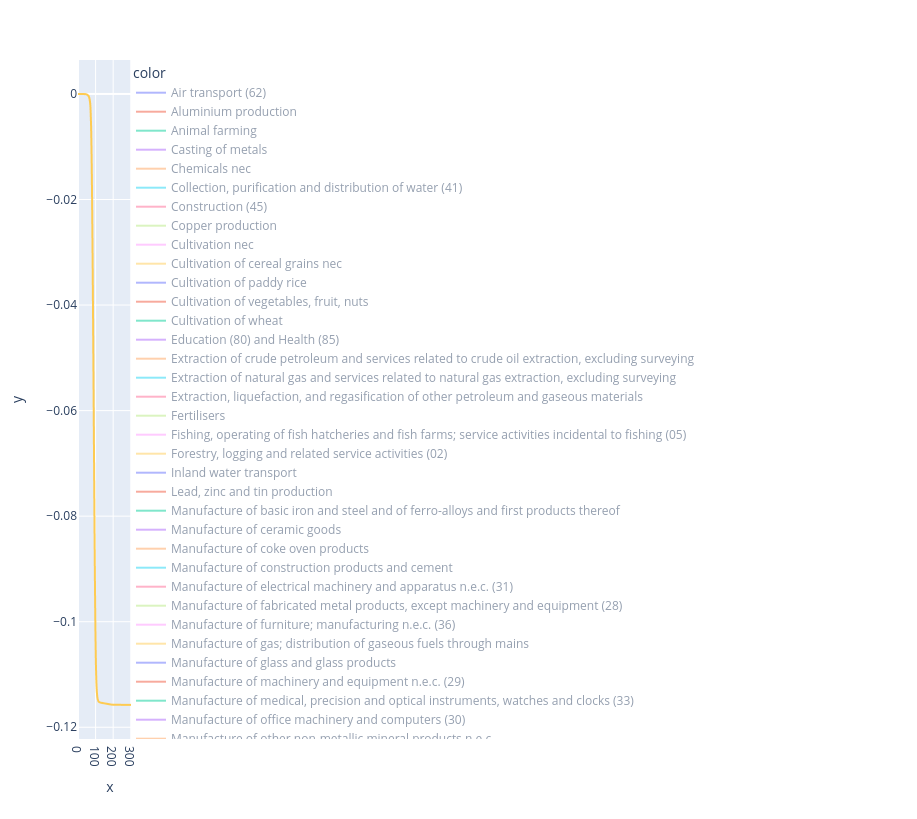

In [36]:
import plotly.express as px

df_stocks = pd.read_feather("../../../Data/BigScaleTest/results/BE_qdmg_2_380962285995726G_Psi_0_9_inv_tau_90/treated_df_stocks.feather")
df_stocks = df_stocks[df_stocks.region=='CN']
#df_stocks = df_stocks[df_stocks.sector=='Manufacture of gas; distribution of gaseous fuels through mains']
#df_stocks
df_stocks = df_stocks.groupby(["step","stock of"]).mean()
df_stocks = df_stocks.reset_index()
df_stocks
fig = px.line(x=df_stocks.step, y=df_stocks.value, color = df_stocks['stock of'])
fig.update_layout(
    autosize=False,
    width=1400,
    height=800,)
fig.show()

In [11]:
df_stocks

step                                           stock of     value
0         0                                 Air transport (62)  0.000000
1         0                               Aluminium production  0.000000
2         0                                     Animal farming  0.000000
3         0                                  Casting of metals  0.000000
4         0                                      Chemicals nec  0.000000
...     ...                                                ...       ...
30290   364                            Transport via pipelines -0.515131
30291   364                             Transport via railways -0.402509
30292   364                                     Waste disposal -0.083794
30293   364  Wholesale trade and commission trade, except o... -0.201354
30294   364                            Wool, silk-worm cocoons  0.016612

[30295 rows x 3 columns]

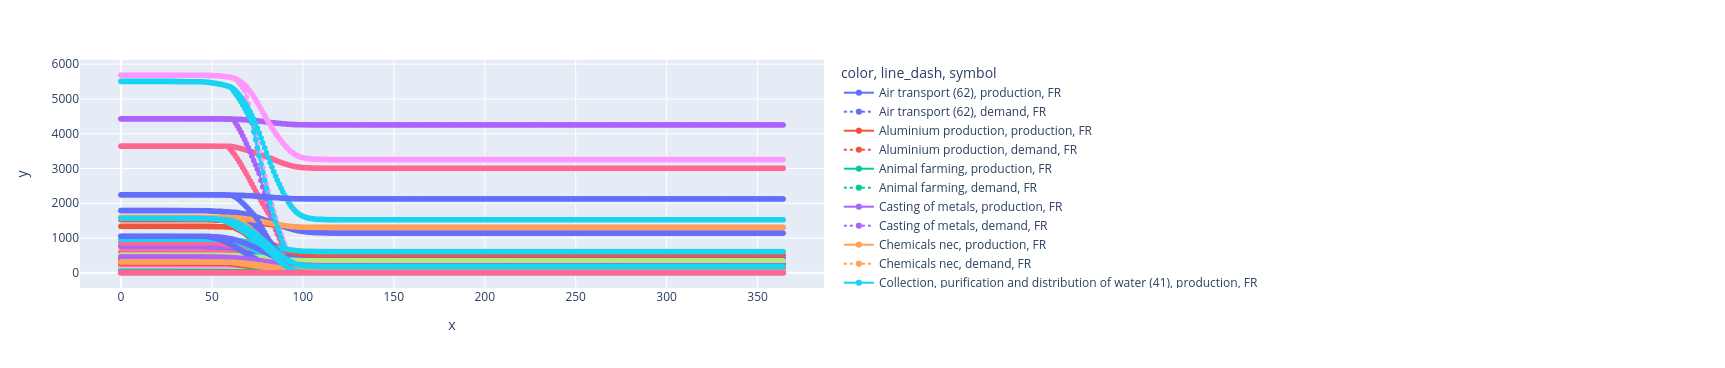

In [10]:
import plotly.express as px
tmp_df = df_prod[(df_prod.variable=='demand') | (df_prod.variable=='production')]
tmp_df = tmp_df[(tmp_df.region=="FR")]
fig = px.line(x=tmp_df.step, y=tmp_df.value, color = tmp_df.sector, line_dash=tmp_df.variable, symbol=tmp_df.region)
fig.show()

In [19]:
import plotly.express as px

sector = 'Construction (45)'
region_selection = ['GB']

dff = df_prod
dff = dff[dff.sector==sector]
dff = dff[dff.step.between(0,49)]
dff = dff[dff.region.isin(region_selection)]
#dff = dff[dff["stock of"].isin(stocks_selection)]
#print(dff.step, dff.value, dff.region, dff.region)
fig = px.line(x=dff.step, y=dff.value, symbol = dff.region, color = dff['stock of'])


AttributeError: 'DataFrame' object has no attribute 'region'

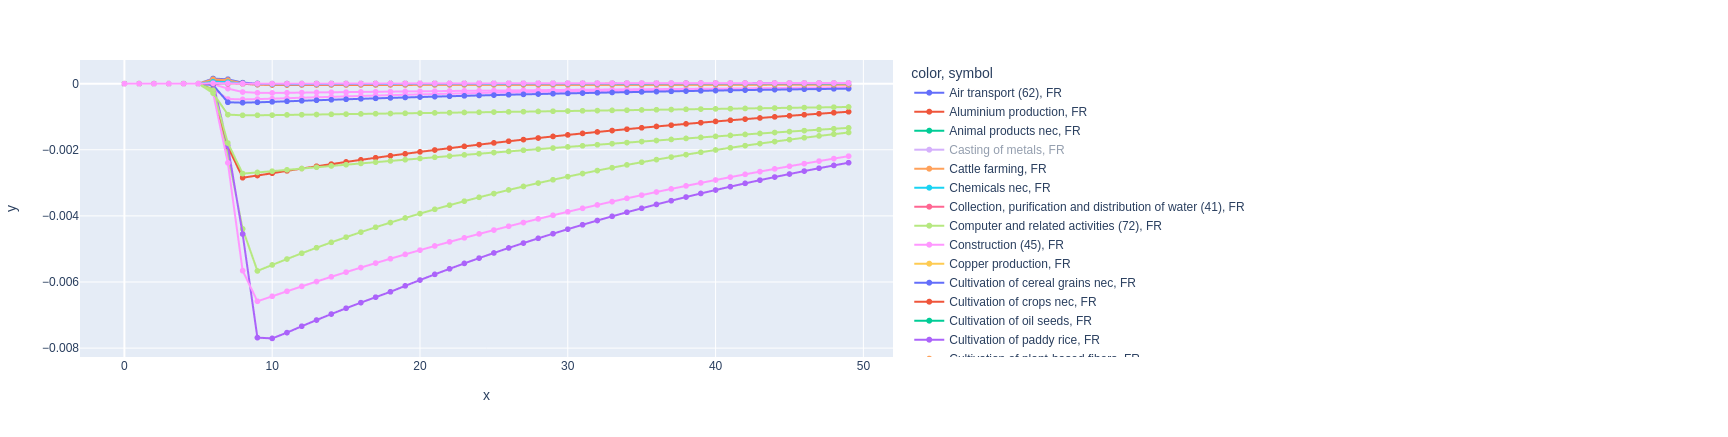

In [41]:
fig.show()

In [10]:
import numpy as np
import pandas as pd
import json
import pathlib

with (pathlib.Path("./BigScaleTest/indexes/indexes.json")).open() as f:
    indexes = json.load(f)

#self.stocks_evolution = np.memmap(result_storage/"stocks_record", dtype='float64', mode="w+", shape=(simulation_params['n_timesteps'], self.n_sectors, self.n_sectors*self.n_regions))
#

data=np.load('./BigScaleTest/results/matrix_stock_dump.pkl', allow_pickle=True)
data.shape

df=pd.DataFrame(data, index=indexes['sectors'], columns=pd.MultiIndex.from_product([indexes["regions"], indexes["sectors"]]))
df

df[df<0].dropna(how='all').dropna(how='all', axis=1)

WL
                                                   Re-processing of secondary steel into new steel
Collection, purification and distribution of wa...                                   -1.583588e-10

In [74]:
import numpy as np
import pandas as pd
import json
import pathlib

with (pathlib.Path("./BigScaleTest/indexes/indexes.json")).open() as f:
    indexes = json.load(f)

results_path = pathlib.Path("./BigScaleTest/results/BE_qdmg_5_0G_Psi_0_8_inv_tau_40/")

t = 365
steps = [i for i in range(t)]


data = np.memmap(results_path/"limiting_stocks_record", mode='r+', dtype='bool',shape=(t*indexes['n_sectors'],indexes['n_industries']))
limiting = pd.DataFrame(data.reshape(t*indexes["n_sectors"],-1),
                                        index=pd.MultiIndex.from_product([steps, indexes["sectors"]], names=['step', 'stock of']),
                                        columns=pd.MultiIndex.from_product([indexes["regions"], indexes["sectors"]], names = ['region','sector']))

limiting

a = limiting.stack([0,1])
#a.index = a.index.rename(['step','sector', 'region']) #type: ignore
a = a.swaplevel(1,2).swaplevel(2,3)
a

step  region  sector                                                                               stock of               
0     AT      Air transport (62)                                                                   Air transport (62)         False
              Aluminium production                                                                 Air transport (62)         False
              Animal farming                                                                       Air transport (62)         False
              Casting of metals                                                                    Air transport (62)         False
              Chemicals nec                                                                        Air transport (62)         False
                                                                                                                              ...  
364   ZA      Transport via pipelines                                                

In [ ]:
import numpy as np
import pandas as pd
import json
import pathlib

with (pathlib.Path("./BigScaleTest/indexes/indexes.json")).open() as f:
    indexes = json.load(f)

results_path = pathlib.Path("./BigScaleTest/results/GB_qdmg_5_0G_Psi_0_9_inv_tau_90/")

t = 365
steps = [i for i in range(t)]


data = np.memmap(results_path/"prod_share_rebuild_record", mode='r+', dtype='float64',shape=(t,indexes['n_industries']))
prod = pd.DataFrame(data = data, index=pd.Index(steps, name='step'),
                    columns=pd.MultiIndex.from_product([indexes["regions"], indexes["sectors"]], names = ['region','sector']))

display_f(prod[('GB', 'Construction (45)')])

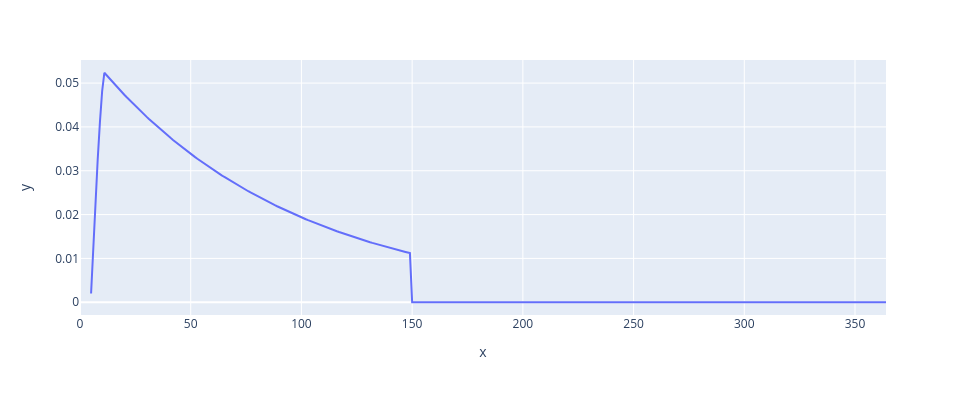

In [33]:
tmp_df = prod[('GB', 'Construction (45)')]
#.groupby(level=1,axis=1).mean()
type(tmp_df)
fig = px.line(x=tmp_df.index, y=tmp_df.values)
fig.show()

In [121]:
X_0 = prod.iloc[0].values
production = prod.iloc[100].values

checker = np.full(production.shape, 0.0)
res = np.full(production.shape, 0.0)
mask = X_0 != 0
np.subtract(X_0, production, out=checker, where=mask)
np.divide(checker, X_0, out=res, where=mask)
np.where(res >= 0.95)[0].size


1654

In [8]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

pymrio==0.4.5
numpy==1.20.0
pandas==1.2.5


In [9]:
import progressbar

progressbar.__version__

'3.55.0'